<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Time Series Observation
 
 
## Detector1Pipeline() test

<span style="color:red"> **Instruments Affected**</span>: MIRI

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.


* astropy.io for opening fits files
* astropy.utils for remote data retrieval
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot



[Top of Page](#title_ID)

In [92]:
# from astropy.io import fits
import inspect
import numpy as np
import glob
from IPython.display import Markdown
from jwst.datamodels import RampModel, ImageModel, CubeModel
from jwst.pipeline import Detector1Pipeline
import matplotlib.pyplot as plt

import astropy.io.fits as fits
from astropy.utils.data import download_file

from pysiaf import Siaf

%matplotlib inline


<a id="intro_ID"></a>
# Introduction

In this notebook we're testing the Detector1Pipeline() step for MIRI Low Resolution Spectroscopy (LRS) Time Series Observations (TSOs). The step takes the Level 1 data and converraw counts to DN/s units (the "ramps to slopes" stage). This is not a TSO-specific step, so we test to ensure the pipeline runs without crashing and executes the stage as planned; there is a dedicated configuration file for stage 1 processing for TSOs, calwebb_tso1.cfg.

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1

Pipeline code: https://github.com/spacetelescope/jwst/blob/master/jwst/pipeline/calwebb_detector1.py


### Calibration WG Requested Algorithm: 

A short description and link to the page: 


### Defining Term
Here is where you will define terms or acronymns that may not be known a general audience (ie a new employee to the institute or an external user). For example

* JWST: James Webb Space Telescope
* MIRI: Mid-Infrared Instrument
* LRS: Low Resolution Spectrometer
* TSO: Time Series Observation


[Top of Page](#title_ID)

<a id="markdown_from_docs"></a>
# Get Documentaion String for Markdown Blocks

In [49]:
# Get raw python docstring
raw = inspect.getdoc(RampModel)

# To convert to markdown, you need convert line breaks from \n to <br />
markdown_text = "<br />".join(raw.split("\n"))

# Here you can format markdown as an output using the Markdown method.
Markdown("""
# RampModel
---
{}
""".format(markdown_text))


# RampModel
---
A data model for 4D ramps.<br /><br />Parameters<br />__________<br />data : numpy float32 array<br />     The science data<br /><br />pixeldq : numpy uint32 array<br />     2-D data quality array for all planes<br /><br />groupdq : numpy uint8 array<br />     4-D data quality array for each plane<br /><br />err : numpy float32 array<br />     Error array<br /><br />zeroframe : numpy float32 array<br />     Zeroframe array<br /><br />group : numpy table<br />     group parameters table<br /><br />int_times : numpy table<br />     table of times for each integration


<a id="data_ID"></a>
# Loading Data

We are using here a simulated TSO observation, generated with MIRISim. It is a single exposure of a star with 100 groups per integration and 200 integrations. LRS TSOs uses the SLITLESSPRISM subarray, so the data do not cover the full array. 

The data are stored on Box and we will retrieve from there.

[Top of Page](#title_ID)

In [50]:
mainurl ="https://data.science.stsci.edu/redirect/JWST/TSO/pipeline_testing_miri_LRS_tso/"
fname = 'pipetest_miri_lrs_tso_100G10I.fits'
fdld = download_file(mainurl+fname)
hdu = fits.open(fdld)
hdu.info()
# dm = some code to create datamodel

Filename: /var/folders/lf/br5qbz194xd6951d98qqk2ym0000gn/T/astropy-download-62876-j6k1pvjh
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     116   ()      
  1  SCI           1 ImageHDU        51   (72, 416, 100, 10)   float32   
  2  PIXELDQ       1 ImageHDU        11   (72, 416)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (18, 416, 100, 10)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5990B]   


### Check the data dimensions against the SIAF

In [53]:
def verify_data(hdu, aperture, tso=True):
    ''' This function will verify the format of the data extensions against the SIAF information and header keywords.
    '''
    siaf = Siaf(instrument='MIRI')
    ap = siaf[aperture]

    ap_corners = ap.corners(to_frame='det')
    ap_rows = np.int(ap_corners[1][2]-ap_corners[1][1])
    ap_cols = np.int(ap_corners[0][1]-ap_corners[0][0])
    
    h = hdu[0].header
    h_groups = h['NGROUPS']
    h_ints= h['NINTS']
    
    # these checks are generally applicable for all types of exposures
    assert np.shape(hdu['SCI'])[3] == ap_cols, "Dimensions of SCI extension don't match the SIAF"
    assert np.shape(hdu['SCI'])[2] == ap_rows, "Dimensions of SCI extension don't match the SIAF"
    assert np.shape(hdu['SCI'])[1] == h_groups, "Dimensions of SCI extensions don't match the header keyword (groups)"
    assert np.shape(hdu['SCI'])[0] == h_ints, "Dimensions of SCI extensions don't match the header keyword (integrations)"
    
    assert np.shape(hdu['PIXELDQ'])[0] == ap_rows, "Dimensions of PIXELDQ extension don't match the SIAF"
    assert np.shape(hdu['PIXELDQ'])[1] == ap_cols, "Dimensions of PIXELDQ extension don't match the SIAF" 
    
    assert np.shape(hdu['REFOUT'])[3] == np.int(ap_cols/4), "Dimensions of REFOUT extension are incompatible with the SIAF"
    assert np.shape(hdu['REFOUT'])[2] == ap_rows, "Dimensions of REFOUT extension don't match the SIAF"
    assert np.shape(hdu['REFOUT'])[1] == h_groups, "Dimensions of REFOUT extensions don't match the header keyword (groups)"
    assert np.shape(hdu['REFOUT'])[0] == h_ints, "Dimensions of REFOUT extensions don't match the header keyword (integrations)"
    
    # this check only needs to be run for TSO exposures:
    if (tso==True):
        assert h['TSOVISIT'], "TSOVISIT keyword not set to True"
    



In [54]:
#print(np.shape(hdu['REFOUT']))
verify_data(hdu, 'MIRIM_SLITLESSPRISM')

Let's make some plots:

* look at the last frame in an integration for a counts check
* plot the ramp for a pixel on and off the spectrum.

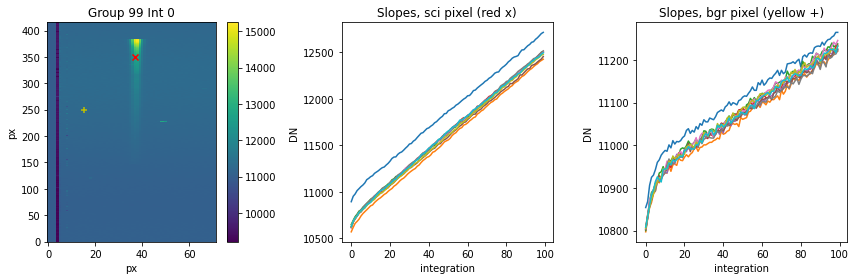

In [55]:
sci_data = hdu['SCI'].data
pri_h = hdu[0].header

ngroups = pri_h['NGROUPS']
nints = pri_h['NINTS']

# identify a science pixel
sci_px = [350, 37]

# identify a pixel in blank sky
bgr_px = [250, 15]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12,4])

# plot 1: frame[-1] in the first integration
lastgrp = ax[0].imshow(sci_data[0,ngroups-1,:,:], origin='lower', interpolation='None', aspect='auto')
ax[0].scatter(sci_px[1], sci_px[0], marker='x', color='r', label='sci pixel')
ax[0].scatter(bgr_px[1], bgr_px[0], marker='+', color='y', label='bgr pixel')
ax[0].set_title('Group {} Int 0'.format(ngroups-1))
ax[0].set_xlabel('px')
ax[0].set_ylabel('px')

# plot 2: pixel slope, spectrum

ax[1].set_title('Slopes, sci pixel (red x)')
for i in range(nints):
    ax[1].plot(sci_data[i, :, sci_px[0], sci_px[1]])
ax[1].set_xlabel('integration')
ax[1].set_ylabel('DN')

# plot 3: pixel slope, background

ax[2].set_title('Slopes, bgr pixel (yellow +)')
for i in range(nints):
    ax[2].plot(sci_data[i, :, bgr_px[0], bgr_px[1]])
ax[2].set_xlabel('integration')
ax[2].set_ylabel('DN')

fig.colorbar(lastgrp, ax=ax[0])
fig.tight_layout()




### Check that the file can be loaded as data model

In [57]:
sci_mod = RampModel(hdu)

<a id="pipeline_ID"></a>
# Run JWST Pipeline

Here we run the Detector1Pipeline() step on the data, using all default inputs. 

[Top of Page](#title_ID)

In [61]:
#output = PipelineStep.call(dm)

step = Detector1Pipeline()
det1 = step.call(sci_mod, save_results=True)


2020-07-22 15:04:04,156 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2020-07-22 15:04:04,158 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2020-07-22 15:04:04,160 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2020-07-22 15:04:04,162 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2020-07-22 15:04:04,164 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2020-07-22 15:04:04,202 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2020-07-22 15:04:04,205 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2020-07-22 15:04:04,208 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2020-07-22 15:04:04,210 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2020-07-22 15:04:04,213 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2020-07-22 

2020-07-22 15:04:04,773 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'astropy-download-62876-j6k1pvjh' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2020-07-22 15:04:04,783 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_dark_0048.fits'.
2020-07-22 15:04:04,784 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.
2020-07-22 15:04:04,785 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits'.
2020-07-22 15:04:04,786 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.
2020-07-22 15:04:0

2020-07-22 15:04:09,682 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits
2020-07-22 15:04:09,818 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2020-07-22 15:04:10,104 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(10, 100, 416, 72) from astropy-download-62876-j6k1pvjh>,).
2020-07-22 15:04:10,105 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2020-07-22 15:04:10,122 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_dark_0048.fits
2020-07-22 15:04:10,664 

2020-07-22 15:05:22,085 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2020-07-22 15:05:22,387 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(416, 72) from astropy-download-62876-j6k1pvjh>,).
2020-07-22 15:05:22,388 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}
2020-07-22 15:05:22,418 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2020-07-22 15:05:22,419 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2020-07-22 15:05:22,422 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2020-07-22 15:05:22,679 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_sca

In [62]:
det1?

<a id="residual_ID"></a>
# Output checks

We will not look into the individual outputs of the steps as the algorithms should be similar to non-TSO observations. Items to verify:

* can both the rate and rateints file be loaded as a datamodel?
* plot the time series in DN/s of the rateints file
* are the values in the rateints file comparable with that seen in the rate file?
* is the rate seen for the sci & background pixels consistent with the ramp values seen in DN?



[Top of Page](#title_ID)

### Load in the output files

These were stored in the working directory with extensions \_rate.fits and \_rateints.fits. The rate file is compatible with the ImageModel, rateints file with CubeModel.

In [99]:
rfile = glob.glob('*_rate.fits')
rifile = glob.glob('*_rateints.fits')
print(rfile)
print(rifile)

rmod = ImageModel(rfile[0])
rimod = CubeModel(rifile[0])



['astropy-download-62876-j6k1pvjh_rate.fits']
['astropy-download-62876-j6k1pvjh_rateints.fits']


### Simple format checks

In [100]:
print('Shape of the rate file: {}'.format(np.shape(rmod.data)))
print('Shape of the rateints file: {}'.format(np.shape(rimod.data)))

assert np.shape(rimod)[1] == np.shape(rmod)[0], "Shapes of rate and rateints file don't match"
assert np.shape(rimod)[2] == np.shape(rmod)[1], "Shapes of rate and rateints file don't match"
assert np.shape(rimod)[0] == nints, "Shape of rateints model doesn't match the exposure specification"
assert np.shape(rimod)[1] == np.shape(sci_mod)[2], "Shape of output doesn't match input model"
assert np.shape(rimod)[2] == np.shape(sci_mod)[3], "Shape of output doesn't match input model"



Shape of the rate file: (416, 72)
Shape of the rateints file: (10, 416, 72)


### Produce plots

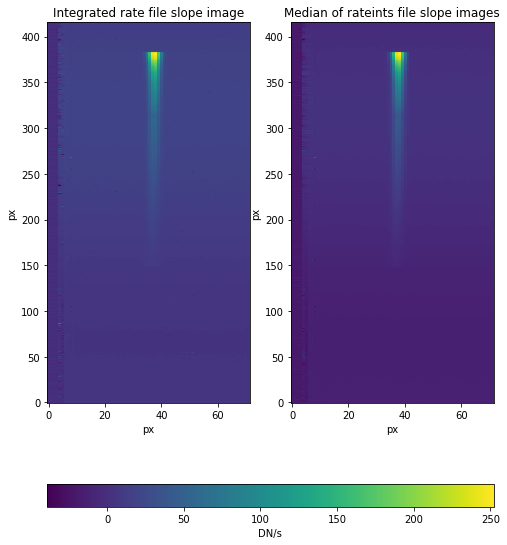

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8,10])

rplt = ax[0].imshow(rmod.data, origin='lower', aspect='auto', interpolation='None')
ax[0].set_title('Integrated rate file slope image')
ax[0].set_xlabel('px')
ax[0].set_ylabel('px')

riplt = ax[1].imshow(np.median(rimod.data, axis=0), origin='lower', aspect='auto', interpolation='None')
ax[1].set_title('Median of rateints file slope images')
ax[1].set_xlabel('px')
ax[1].set_ylabel('px')

cbar = fig.colorbar(rplt, ax=ax, orientation='horizontal')
cbar.set_label('DN/s')
#fig.tight_layout()


<a id="about_ID"></a>
## About this Notebook
**Author:** Author Name, Job Title, Branch Name
<br>**Updated On:** MM/DD/YYYY

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 